In [27]:
%run '0.0_init_configuration.ipynb'

### Logistic Regression

The objective is to classify the activities the participants performed into one of the six following categories:

- Walking
- Walking upstairs
- Walking downstairs
- Sitting
- Standing
- Laying

The following information is provided for each record in the dataset:

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration
- Triaxial Angular velocity from the gyroscope
- A 561-feature vector with time and frequency domain variables
- The activity label

**Question 1**

Import the data and do the following:

- Examine the data types--there are many columns, so it might be wise to use value counts.
- Determine if the floating point values need to be scaled.
- Determine the breakdown of each activity.
- Encode the activity label as an integer.

In [28]:
# Begin Solution

df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,STANDING


The data columns are all floats except for the activita label.



In [29]:
df.dtypes.value_counts()

float64    561
object       1
Name: count, dtype: int64

In [30]:
df.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

In [31]:
# Descartamos la variable objetivo y vemos los rangos de las columnas
df.iloc[:,:-1].min().value_counts()

-1.0    561
Name: count, dtype: int64

In [32]:
df.iloc[:,:-1].max().value_counts()

1.0    561
Name: count, dtype: int64

In [33]:
df.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.

Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.



In [36]:
# LabelEncoder se usa para la variable objetivo en problemas de clasificación
le = LabelEncoder()
df['Activity'] = le.fit_transform(df.Activity)
df['Activity'].sample(5)

321     5
4992    3
340     4
4942    1
1623    2
Name: Activity, dtype: int64

### Question 2

- Calculate the correlations between the dependent variables.
- Create a histogram of the correlation values.
- Identify those that are most correlated (either positively or negatively).

In [41]:
# Calculate the correlation values
features_cols = df.columns[:-1]
corr_values = df[features_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs:
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.nan

# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack() # conver the matrix to a pair list
               .to_frame()
               .reset_index()
               .rename(columns={'level_0' : 'feature1',
                                'level_1' : 'feature2',
                                0 : 'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

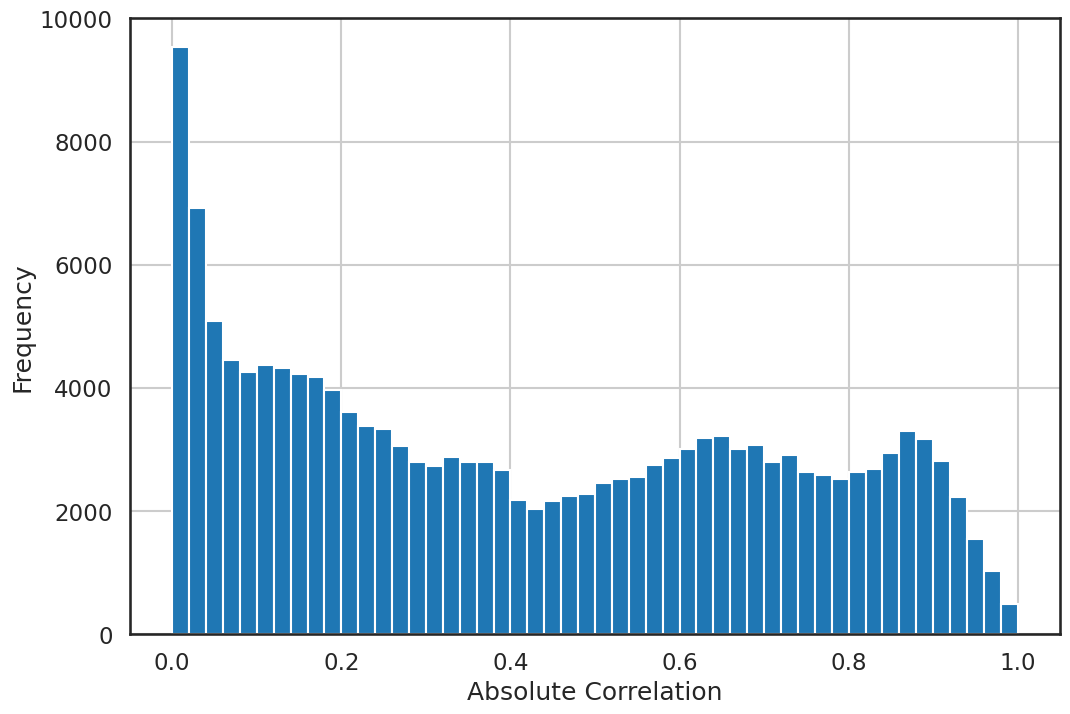

In [42]:
# Graph
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12,8))
ax.set(xlabel = 'Absolute Correlation', ylabel='Frequency')

plt.show()

- La mayoría de los pares de variables tienen baja correlación (concentración en valores cercanos a 0.0).

- Sin embargo, también hay bastantes pares que tienen correlación alta (picos hacia la derecha, entre 0.8 y 1.0).

- ✅ Aunque muchas variables son poco correlacionadas (buen para los modelos)

- 🚩 Hay pares de variables muy altamente correlacionadas (potencial problema de multicolinealidad).

In [43]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
156556,fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
96366,tBodyAccMag-arCoeff()4,tGravityAccMag-arCoeff()4,1.000000,1.000000
109498,tBodyGyroJerkMag-mean(),tBodyGyroJerkMag-sma(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


### Question 3
- Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.

- Regardless of the method used to split the data, compare the ratio of classes in both the train and test splits.

In [44]:
# Get the split index using StratifiedShuffleSplit method 
strat_shuf_split = StratifiedShuffleSplit(n_splits= 1,
                                          test_size= 0.3,
                                          random_state= 42)

train_idx, test_idx = next(strat_shuf_split.split(df[features_cols], df.Activity))

#Create dataframe
X_train = df.loc[train_idx, features_cols]
y_train = df.loc[train_idx, 'Activity']

X_test = df.loc[test_idx, features_cols]
y_test = df.loc[test_idx, 'Activity']

Estan proporcionalmente divididos

In [45]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [46]:
y_test.value_counts(normalize=True)

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

### Question 4

- Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.

- Using cross validation to determine the hyperparameters and fit models using L1 and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

solver = liblinear: Adecuado para conjunto de datos pequeños o cuando se unsa regularización L1 (lasso), resuleve problemas de optimización usando método de "descenso de grandiente"

- 'newton-cg': para problemas más grandes y con regularización L2.

- 'lbfgs': similar a 'newton-cg', pero más eficiente para datos grandes.

- 'sag' y 'saga': para grandes cantidades de datos y soportan tanto L1 como L2. En este caso, liblinear es rápido y funciona bien para conjuntos de datos pequeños o medianos.

- Cs = 10, especifica el número de valores diferentes de la constante de regularización C que evaluara durante la validación cruzada.

- cv = 4 validación cruzada de 4 particiones

In [47]:
# Standard Logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

# L1 Regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

### Question 5

- Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.

In [ ]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab, mod in zip(coeff_labels, coeff_models):
    # Extraemos los coeficientes del modelo
    coeffs = mod.coef_
    # Usamos del 0 a 5 por nuestra variable y
    coeff_label = pd.MultiIndex(levels = [[lab], [0, 1, 2, 3, 4, 5]],
                                codes = [[0,0,0,0,0,0] , [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns = coeff_label))

coefficients = pd.concat(coefficients, axis = 1)
coefficients.sample(10)

lr                                                     l1  \
            0         1         2         3         4         5    0   
242  0.016123 -0.078789  0.061986 -0.731071  0.464251 -0.069518  0.0   
420 -0.005261  0.141068  0.178015 -0.158858  0.417940 -0.049662  0.0   
362 -0.008299  0.150404  0.159462 -0.077875  0.172477 -0.038006  0.0   
478  0.003130  0.239679  0.275174  0.160749  0.186584  0.378035  0.0   
106 -0.141034  0.320384 -0.184481 -0.166063 -0.654003 -0.029494  0.0   
488 -0.022468  0.055810  0.245970  0.224081 -0.299632  0.448566  0.0   
349 -0.029105  0.068656 -0.224751  0.253451  0.117788 -0.331295  0.0   
441 -0.028303  0.025842  0.180567 -0.147768 -0.094862  0.167677  0.0   
14   0.034446  0.498537 -0.199548 -0.050162 -0.417236 -0.242146  0.0   
435  0.009718  0.252145  0.100116  0.097109  0.297673  0.155978  0.0   

                                                             l2            \
            1         2         3         4         5         0         1   
242  0.000000  0.000000 -1.343559  1.320111 -0.068730  0.040247 -0.381342   
420  0.000000  0.000000  0.000000  0.589807  0.000000 -0.028151  0.295745   
362  0.000000  0.000000  0.000000  0.060560  0.000062 -0.033990  0.395432   
478  0.263315  0.440762  0.021588  0.046304  0.309848 -0.016685  0.659248   
106  0.176061 -0.309373  0.000000 -2.987152  0.000000 -0.283655  3.215194   
488  0.000000  0.053223  0.225248 -0.076713  0.447579 -0.047652  0.121278   
349  0.000000  0.000000  0.000000  0.000000 -0.190514 -0.055256  0.373336   
441  0.000000  0.000000  0.000000 -0.028665  0.000000 -0.057300 -0.053856   
14   1.629536  0.000000  0.000000 -1.111938  0.000000  0.041335  2.559766   
435  1.327784  0.000000  0.000000  0.139421  0.578238  0.003103  1.942222   

                                             
            2         3         4         5  
242  0.075471 -2.144274  0.939077 -0.270598  
420  0.217694 -0.469923  0.921989  0.080046  
362  0.194423 -0.247553  0.268100 -0.056243  
478  0.344223  0.468262  0.318925  0.763425  
106 -0.742557 -0.670256 -1.394899  0.018743  
488  0.394403  0.765245 -0.672375  0.768446  
349 -0.360087  0.658442  0.198707 -0.631711  
441  0.289034 -0.379494 -0.171926  0.232175  
14  -0.507005 -0.264288 -0.812179 -0.581879  
435 -0.124890  0.152895  0.541015  0.333568

- Los coeficientes indican cuánto afecta esa variable al resultado de la predicción.

- 1️⃣ l1 (Lasso):
    - Muchos coeficientes son 0.0 → L1 hace selección de variables automáticamente.

        Por ejemplo:

    - Feature 0, 1 y 2 fueron eliminados (0.0).

    - Esto quiere decir que el modelo l1 considera que esas variables no aportan mucho a la predicción.

- 2️⃣ l2 (Ridge):
    - Los coeficientes no se van a cero, pero son reducidos en magnitud.

    - El Ridge tiende a "suavizar" los pesos para evitar overfitting.

        Por ejemplo:

    - Feature 1: -0.381342 en l2 vs -0.078789 en lr.

    - El Ridge penalizó un poco más fuerte ese coeficiente.

- 3️⃣ lr (Regresión lineal pura):
    - Aquí no hay ninguna penalización.

    - Los coeficientes toman el valor puro del ajuste sobre los datos de entrenamiento.

    - Puede tener overfitting si los datos tienen multicolinealidad o ruido.


In [62]:
# # Creamos subplots de 6 ejes(axes) axList
# fig, axList = plt.subplots(nrows=3, ncols=2)

# #Flatten convierte en un arrada 1D
# axList = axList.flatten()

# fig.set_size_inches(10,10)

# for ax in enumerate(axList):
#     # numero del feature actual [0 a 5]
#     loc = ax[0]
#     # Eje donde va a dibuar
#     ax = ax[1]

#     # .xs() corte transversal, busca las columnas lvl 1 = al loc
#     data = coefficients.xs(loc, level=1, axis=1)
#     data.plot(marker = 'o', ls='', ms=2.0, ax=ax, legend=False)

#     # Añadimos leyenda al primer grafico
#     if ax is axList[0]:
#         ax.legend(loc=4)
    
#     ax.set(title='Coefficinet Set' + str(loc))

# plt.tight_layout()
# plt.show()

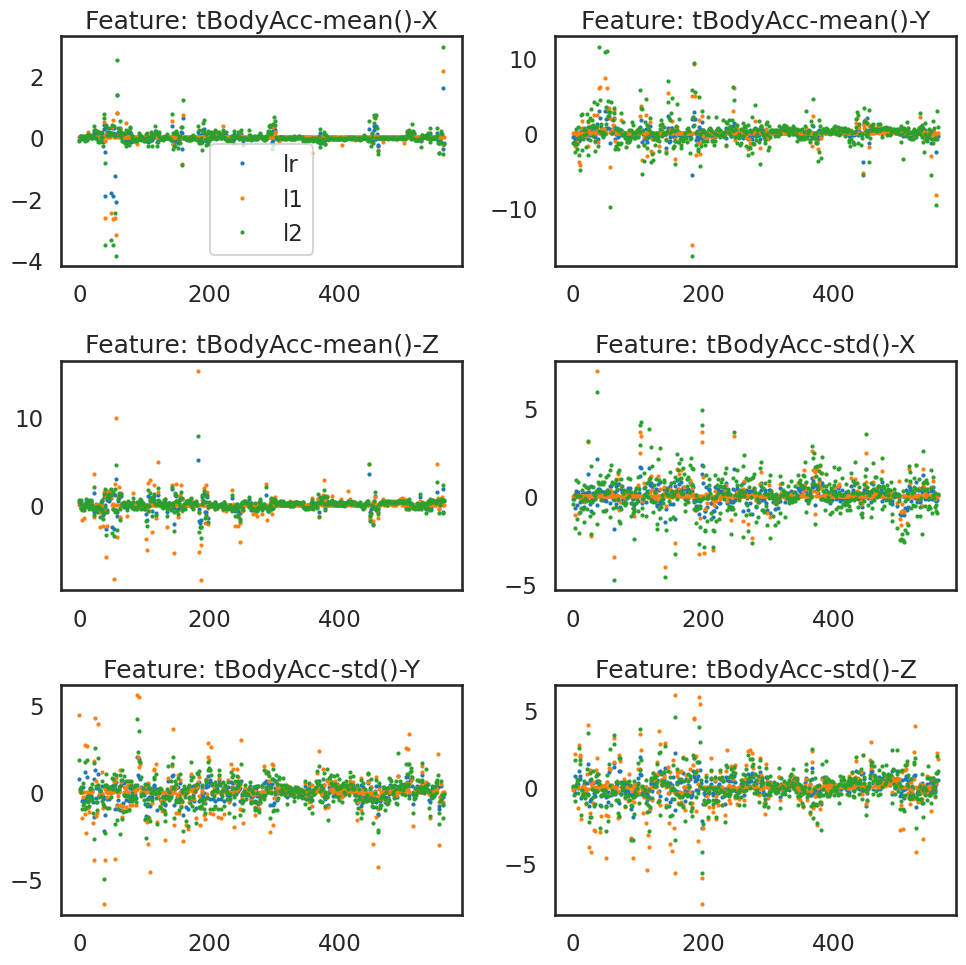

In [ ]:
# Otra forma
feature_names = X_train.columns.tolist()  # si entrenaste con pandas

# Crear los subplots
fig, axList = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
axList = axList.flatten()

# Loop limpio
for i, ax in enumerate(axList):
    
    # Extraer los datos del feature correspondiente
    data = coefficients.xs(i, level=1, axis=1)

    # Graficar
    data.plot(marker='o', linestyle='', markersize=2, ax=ax, legend=(i==0))
    
    # Título con el nombre real de la variable
    ax.set_title(f'Feature: {feature_names[i]}')
    


plt.tight_layout()
plt.show()


### Question 6

- Predict and store the class for each model.
- Store the probability for the predicted class for each model.

In [ ]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab, mod in zip(coeff_labels, coeff_models):
    #Hacemos predicciones en los 3 modelos en el grupo de prueb X_test
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))

y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [72]:
y_prob.head()


,lr,l1,l2
0,0.998939,0.998855,0.999757
1,0.988165,0.999432,0.999489
2,0.987592,0.995457,0.999657
3,0.981381,0.999161,0.994339
4,0.998277,0.999919,0.999997


### Question 7

For each model, calculate the following error metrics:

- Accuracy
- Precision
- Recall
- F-score
- Confusion Matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [90]:
metrics = list()
cm = dict()

# Prepara el binarizador
binarizer = LabelBinarizer()
binarizer.fit([0, 1, 2, 3, 4, 5])

for lab in coeff_labels:
    # Precision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')

    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])

    #ROC-AUC scores can be calculated by binarizing the data
    # Binariza los datos
    y_test_bin = binarizer.transform(y_test)
    y_pred_bin = binarizer.transform(y_pred[lab])

    # Calcula el AUC
    auc = roc_auc_score(y_test_bin, y_pred_bin, average='weighted', multi_class='ovr')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])

    metrics.append(pd.Series({'precision':precision, 'recall':recall,
                              'fscore':fscore, 'accuracy': accuracy,
                              'auc':auc},
                              name=lab))
    
metrics = pd.concat(metrics, axis=1)

metrics

,lr,l1,l2
precision,0.984144,0.983844,0.983824
recall,0.984142,0.983819,0.983819
fscore,0.984143,0.983815,0.983819
accuracy,0.984142,0.983819,0.983819
auc,0.990384,0.990145,0.990165


- Todos los modelos tienen muy buen desempeño (accuracy cercano a 98.4%).

- lr (regresión logística sin regularización) tiene un poquitito mejor resultado global (apenas ≈0.03% mejor que los modelos con regularización L1 y L2).

- auc muy alto (~0.99): los modelos son muy buenos discriminando las clases (muy pocas confusiones graves).

- Las diferencias son pequeñísimas, podrías decir que los 3 modelos son prácticamente equivalentes para este dataset.

- Conclusión general de las métricas:

    - El modelo sin regularización (lr) rindió apenas mejor que los penalizados (l1, l2), pero todos predicen muy bien.

### Question 8

- Display or plot the confusion matrix for each model.

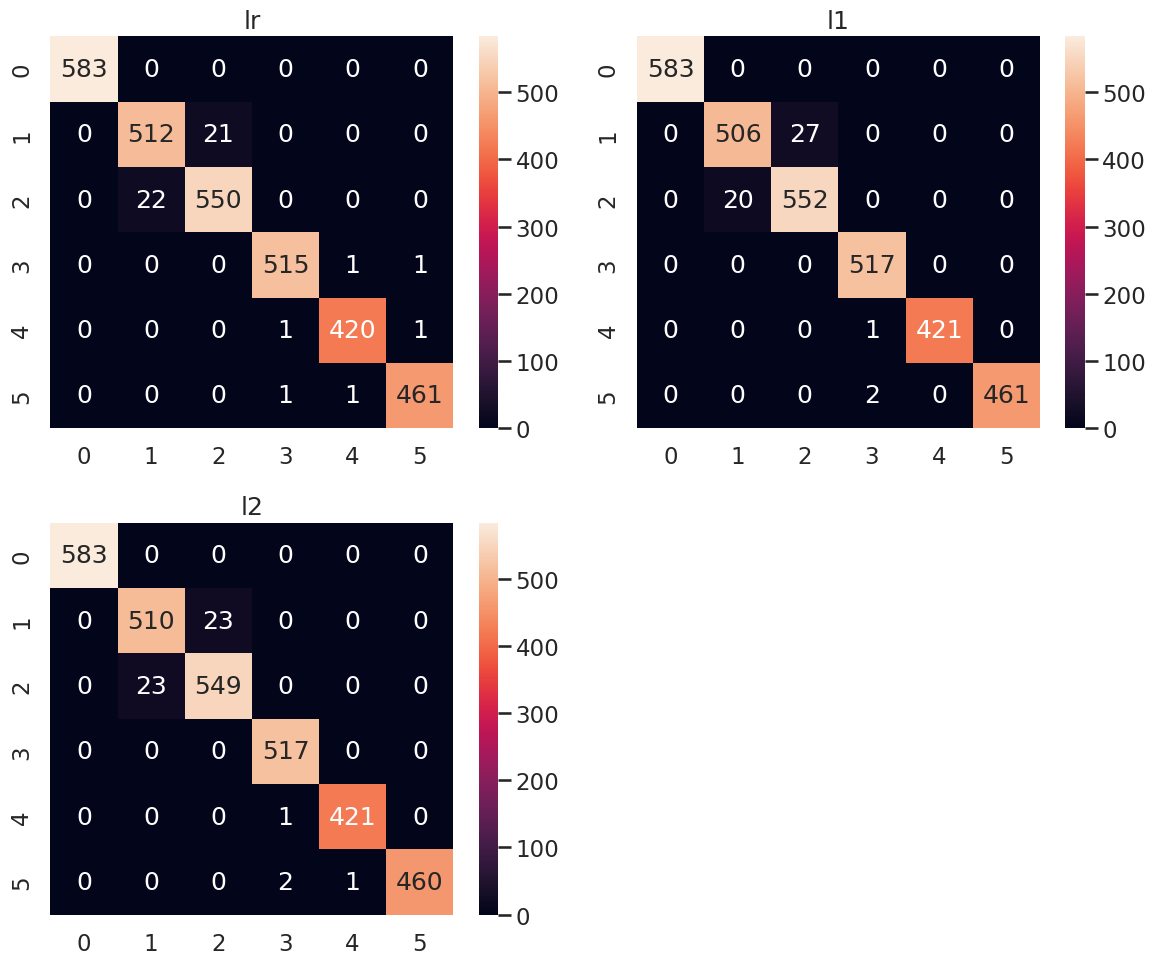

In [91]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12,10)

axList[-1].axis('off')

for ax, lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d')
    ax.set(title=lab)

plt.tight_layout()
plt.show()

**Cosas importantes que vemos:**

- Las clases 0, 3, 4 y 5 están casi perfectas.

- Las únicas confusiones relevantes están en:

    - Clase 1 y 2:

        - El modelo a veces confunde la clase 1 con 2 y viceversa.

        - Por ejemplo, 21 veces predijo 2 cuando era 1, y 22 veces predijo 1 cuando era 2.

        - Esto ocurre en los 3 modelos. Las confusiones son casi idénticas.

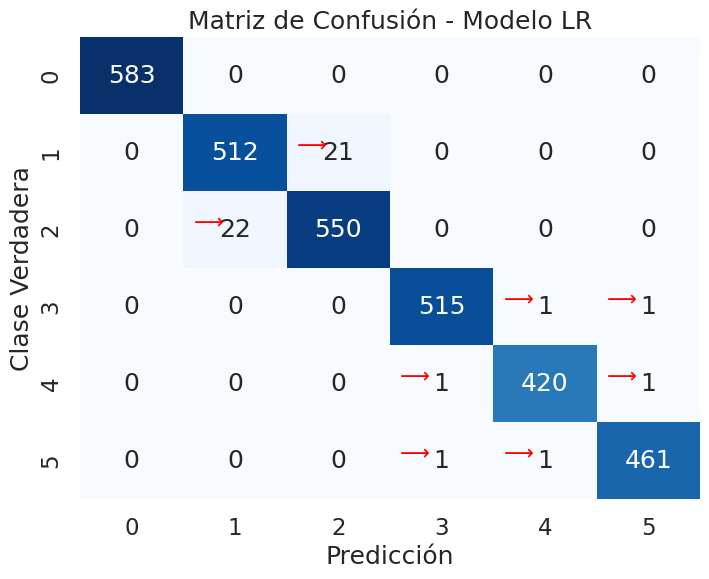

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seleccionemos, por ejemplo, la matriz de confusión de lr
conf_matrix = cm['lr']

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Matriz de Confusión - Modelo LR')
plt.xlabel('Predicción')
plt.ylabel('Clase Verdadera')

# Agregamos líneas para resaltar los errores (fuera de diagonal)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i != j and conf_matrix[i,j] > 0:
            plt.text(j+0.1, i+0.5, f"⟶", color='red', fontsize=15)

plt.show()
